In [1]:
from pydrake.all import (MathematicalProgram, Solve, MonomialBasis,
                         DiagramBuilder, Evaluate, LogVectorOutput, Simulator,
                         SymbolicVectorSystem, Variable, ToLatex, Polynomial,
                         VectorSystem, eq, ge, le, Formula, Expression, Evaluate,
                         LeafSystem, AbstractValue,
                         )

from pydrake.all import (PiecewisePolynomial, ModelInstanceIndex,
    RotationMatrix, RigidTransform, Rgba, Box, Sphere, BaseField,
    Evaluate, Fields, PointCloud, MeshcatAnimation)

from IPython.display import clear_output

import os
import copy
import time
import numpy as np
from typing import Tuple
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
from dataclasses import dataclass
import zarr

from dccm_quasistatic.utils.math_utils import (create_square_symmetric_matrix_from_lower_tri_array,
                                               get_n_lower_tri_from_matrix_dim,
                                               matrix_inverse)
from dccm_quasistatic.utils.sample_generator import (SampleGenerator, SampleGeneratorParams)
from dccm_quasistatic.controller.dccm_params import DCCMParams
from dccm_quasistatic.controller_synthesizer.dccm_synthesizer import DCCMSynthesizer
 
from qsim.parser import (
    QuasistaticParser,
    QuasistaticSystemBackend,
    GradientMode,
)

from qsim.simulator import ForwardDynamicsMode, InternalVisualizationType
from qsim.model_paths import models_dir, package_paths_dict

/home/shaoyuan/Documents/Software/quasistatic_simulator/robotics_utilities/qp_derivatives/qp_derivatives.py:2: DrakeDeprecationWarning: Please import from the pydrake.solvers module directly, instead of the deprecated pydrake.solvers.mathematicalprogram submodule. The deprecated code will be removed from Drake on or after 2023-05-01.
  import pydrake.solvers.mathematicalprogram as mp


In [2]:
from dccm_quasistatic.controller.dccm_controller_wo_inv import DCCMControllerWoInv


plt.rcParams.update({'font.size': 40})
linewidth = 5
def draw_plot(t, q, q_des, u, u_des, geodesic, tracking_error):
    clear_output(wait=True)
    fig, axs = plt.subplots(4, 1, figsize=(45, 32))

    axis = axs[0]
    axis.step(t, q, linestyle='solid', linewidth=linewidth)
    axis.step(t, q_des, linestyle='dashed', linewidth=linewidth)
    axis.legend([r'$b_x$', r'$b_y$', r'$b_{\theta}$', r'$s_x$', r'$s_y$',
                 r'$b^*_x$', r'$b^*_y$', r'$b^*_{\theta}$', r'$s^*_x$', r'$s^*_y$'],
                 ncol=2)
    axis.set_ylabel('state')
    axis.set_xlabel('t')

    axis = axs[1]
    axis.step(t, u, linestyle='solid', linewidth=linewidth)
    axis.step(t, u_des, linestyle='dashed', linewidth=linewidth)
    axis.legend([r'$u_{x}$',r'$u_{y}$', r'$u^*_{x}$',r'$u^*_{y}$'],
                ncol=2)
    axis.set_ylabel('u')
    axis.set_xlabel('t')

    axis = axs[2]
    axis.step(t, geodesic, linewidth=linewidth)
    axis.set_ylabel('geodesic length')
    axis.set_xlabel('t')

    axis = axs[3]
    axis.step(t, tracking_error, linewidth=linewidth)
    axis.set_ylabel('tracking error')
    axis.set_xlabel('t')
    plt.show()

def evaluate_controller(sample_generator_params, dccm_params, traj_id):
    file_prefix = "saved_dccm_coeffs/circ_"
    base_filename = f"samples{sample_generator_params.n_samples}_lbw{sample_generator_params.log_barrier_weight}_deg{dccm_params.deg}_beta{str(dccm_params.beta).split('.')[1]}.npy"
    
    # Set up dynamical system
    package_paths_dict["dccm_quasistatic"] =  "/home/shaoyuan/Documents/Software/dccm_quasistatic"
    q_model_path = os.path.join("../../models", "q_sys", "box_pushing.yml")
    q_parser = QuasistaticParser(q_model_path)
    q_sim = q_parser.make_simulator_cpp()
    q_sim_py = q_parser.make_simulator_py(InternalVisualizationType.Cpp)

    total_duration_s = 10

    # Load dccm coeffs
    wijc = np.load(f"{file_prefix}wijc_{base_filename}")
    lijc = np.load(f"{file_prefix}lijc_{base_filename}")
    dccm_controller = DCCMControllerWoInv(dccm_params, wijc, lijc)
     
    print(f"wijc:\n{dccm_controller._wijc}")
    print(f"lijc:\n{dccm_controller._lijc}")

    # Load desired trajectory
    traj_file_name = f"desired_trajectories/{traj_id}.zarr"
    traj = zarr.open_group(traj_file_name, mode='r')
    q_desired = traj["q_desired"]
    q = traj["q0"]


    sim_p = copy.deepcopy(q_sim.get_sim_params())
    sim_p.h = 0.1
    sim_p.unactuated_mass_scale = 10
    # exact dynamics
    # sim_p.gradient_mode = GradientMode.kNone
    # sim_p.forward_mode = ForwardDynamicsMode.kQpMp
    # Smoothed dynamics
    sim_p.gradient_mode = GradientMode.kAB
    sim_p.log_barrier_weight = sample_generator_params.log_barrier_weight
    sim_p.forward_mode = ForwardDynamicsMode.kLogIcecream

    q_sim_py.update_mbp_positions_from_vector(q)
    q_sim_py.draw_current_configuration()

    meshcat = q_sim_py.meshcat
    def draw_pose_of_box(name, pos, color):
        pose = RigidTransform(RotationMatrix().MakeXRotation(pos[-1]), np.concatenate(([0], pos[0:2])))
        
        meshcat.SetObject(name, Box(1,1,1), rgba=color)
        meshcat.SetTransform(name, pose)

    def visualize_open_loop_traj(q0, q_desired):
        qs = [q0]
        q = q0
        for i, q_des in enumerate(q_desired):
            if i == len(q_desired) - 1:
                break
            u_desired = q_desired[i+1, -2:]
            b_des = q_des[:3]
            draw_pose_of_box("b_des", b_des, Rgba(0, 1, 0, 0.5))
            q_sim_py.update_mbp_positions_from_vector(q)
            q_sim_py.draw_current_configuration()
            time.sleep(0.1)
            q = q_sim.calc_dynamics(q, u_desired, sim_p)
            qs.append(q)
        return np.array(qs)
    
    openloopqs = visualize_open_loop_traj(q, q_desired)

    n_steps = int(total_duration_s / sim_p.h)
    t_log = []
    q_log = []
    u_log = []
    u_desired_log = []
    geodesic_log = []
    success_log = []
    tracking_error_log = []

    for i in range(n_steps):
        t=i*sim_p.h
        t_log.append(t)
        q_log.append(q)
        if i == len(q_desired) - 1:
            break
        u_desired = q_desired[i+1, -2:]
        tracking_error = np.linalg.norm(q - q_desired[i])
        tracking_error_log.append(tracking_error)
        # Dummy data
        # u = u_desired
        # geodesic = 0
        # success = True
        u, geodesic, success = dccm_controller.control_law(q,q_desired[i, :], u_desired, t)
        q = q_sim.calc_dynamics(q, u, sim_p)
        q_sim_py.update_mbp_positions_from_vector(q)
        q_sim_py.draw_current_configuration()
        b_des = q_desired[i+1, :3]
        draw_pose_of_box("b_des", b_des, Rgba(0, 1, 0, 0.1))
        draw_pose_of_box("open loop b", openloopqs[i+1, :3], Rgba(1, 0, 0, 0.1))
        
        u_desired_log.append(u_desired)
        u_log.append(u)
        geodesic_log.append(geodesic)
        success_log.append(success)
        draw_plot(t_log, q_log, q_desired[:i+1, :], u_log, u_desired_log, geodesic_log, tracking_error_log)
        print(f"success: {success_log}")
    
    print(f"total tracking error: ", np.sum(tracking_error_log))
    
    results_file_name = f"results/circ_traj{traj_id}_ngeoseg_{dccm_params.n_geodesic_segments}_{base_filename}.zarr"
    root = zarr.open_group(results_file_name, mode='w')

    root["success"] = success_log
    root["t"] = t_log
    root["q_desired"] = q_desired
    root["u_desired"] = u_desired_log
    root["q"] = q_log
    root["u"] = u_log
    root["geodesic"] = geodesic_log
    root["tracking_error"] = tracking_error_log


In [3]:
# sample_generator_params = SampleGeneratorParams(
#     log_barrier_weight=10,
#     n_samples=500,
#     actuated_collision_geomtery_names=["hand::collision"]
# )

# dccm_params = DCCMParams(
#     dim_x=5,
#     dim_u=2,
#     deg=4,
#     beta=0.1,
#     n_geodesic_segments=1,
# )

# n_samples_list = [100] # already have the results for 2000
# for n_samples in n_samples_list:
#     sample_generator_params.n_samples = n_samples
#     evaluate_controller(sample_generator_params, dccm_params, "A")


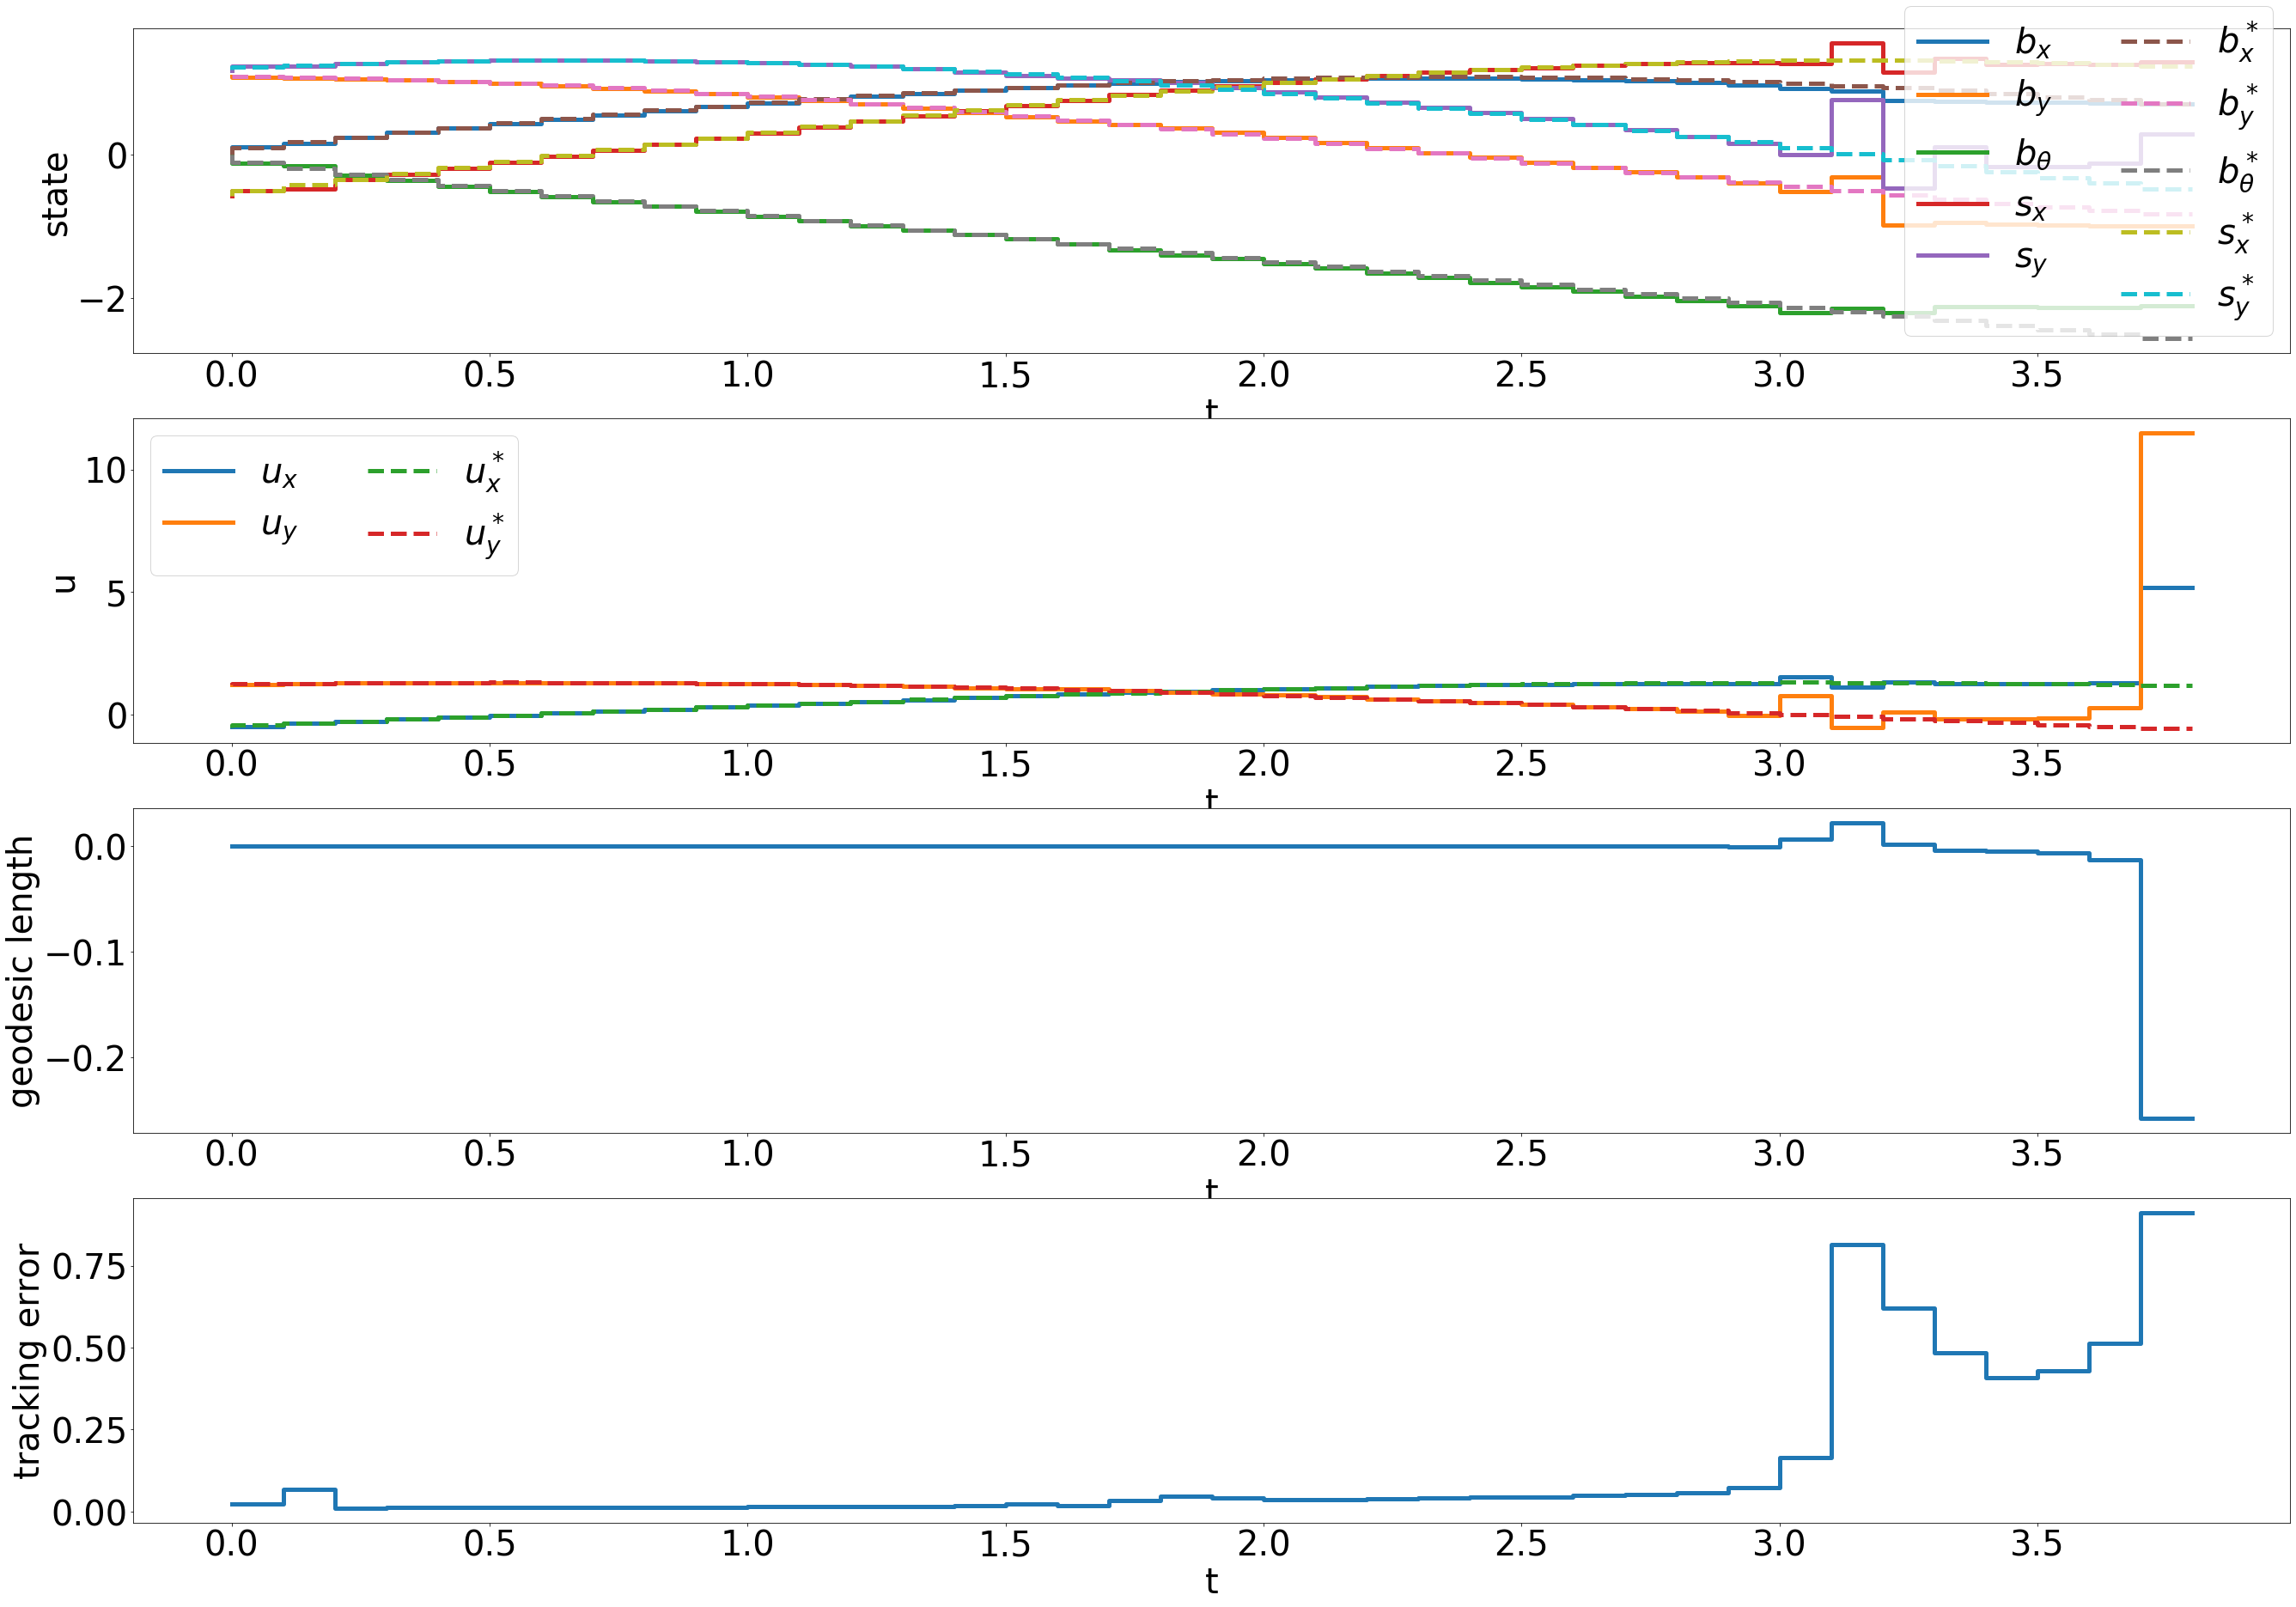

success: [True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]
Calculating geodesic at time: 3.9000000000000004, xk = [ 0.71227449 -0.9943861  -2.09311017  5.19345399 11.48445546], xd = [ 0.66144403 -0.86873603 -2.62769989  1.20366599 -0.55151081], ud = [ 1.16666118 -0.62600134]
calculate_geodesic initialize


KeyboardInterrupt: 

In [4]:
sample_generator_params = SampleGeneratorParams(
    log_barrier_weight=100,
    n_samples=500,
    actuated_collision_geomtery_names=["hand::collision"]
)

dccm_params = DCCMParams(
    dim_x=5,
    dim_u=2,
    deg=6,
    beta=0.1,
    n_geodesic_segments=1,
)

evaluate_controller(sample_generator_params, dccm_params, "C")